<a href="https://colab.research.google.com/github/mdrabic5/SSIP-2021-Age-recognition-project/blob/main/SSIP_2021_age_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import itertools
import cv2
from time import time
from google.colab.patches import cv2_imshow
from google.colab import drive
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalMaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

pd.set_option('display.max_rows', 15000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

# SSIP 2021 - Age recognition project

Recognizing the age of person based on the facial image (the age can be recognized within several classes: teenager, young, middle age, old).

Input: A digital image of a face.  
Output: Age of person in the image.  
Datasets: https://www.face-rec.org/databases/


In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


## Preparing dataset

Before running the training on the data, the date needs to be cleaned and analyzed.  
We have decided to use pandas library to clean the dataset.

As for splitting the dataset to training and testing, the dataset already was split up to 5 folds. So we used first 4 folds for training and the last one for testing. Also, the training dataset was split up to training and validation by 9:1 ratio.

The dataset came with 8 different age groups as the label for the samples, but we have decided to group the into 4 classes.
Those age groups are transformed into numeric value where age groups (0, 2) and (4, 6) are transformed to 0, (8, 12) and (15, 20) are transformed to 1, (25, 32) and (38, 43) are transformed to 2 and (48, 53) and (60, 100) are transformed to 3.

The dataset also had to be cleaned before training the CNN model, we found some wrongly labeled samples and some samples anottated with None.

In [14]:
# Constants
DRIVE_SSIP_DIR = 'drive/MyDrive/SSIP2021/'
METADATA_DIR = DRIVE_SSIP_DIR + 'data/metadata/'
IMAGE_PREFIX = 'landmark_aligned_face.'
IMAGES_DIR = 'drive/MyDrive/SSIP2021/data/images/'
RESULTS_DIR = DRIVE_SSIP_DIR + "results/"
WEIGHT_PATH = RESULTS_DIR + "age_recognition_weights_best.hdf5"

LABEL_DICT = {'(0, 2)':0, '(4, 6)':0, '(8, 12)':1, '(15, 20)':1, '(25, 32)':2, '(38, 43)':2, '(48, 53)':3, '(60, 100)':3}

# Creating pandas DataFrame with whole metadata for training
list_df_train =  []

for i in range(4):
  df = pd.read_csv(METADATA_DIR + 'fold_frontal_' + str(i) + '_data.txt', delimiter = "\t")
  df['face_id'] = df['face_id'].astype('str')
  df['age'] = df['age'].astype('str')
  list_df_train.append(df)

dfs_train = pd.concat(list_df_train, ignore_index=True, sort=False)

# Creating pandas DataFrame with whole metadata for testing
df_test = pd.read_csv(METADATA_DIR + 'fold_frontal_4_data.txt', delimiter = "\t")
df_test['face_id'] = df_test['face_id'].astype('str')
df_test['age'] = df_test['age'].astype('str')


# creating DataFrame with only 'image_path' and 'label' column
df_metadata_train = pd.DataFrame()
df_metadata_test = pd.DataFrame()

df_metadata_train['image_path'] = dfs_train['user_id'] + '/' + IMAGE_PREFIX + dfs_train['face_id'] + '.' + dfs_train['original_image']
df_metadata_train['label'] = dfs_train['age'].map(LABEL_DICT)

df_metadata_test['image_path'] = df_test['user_id'] + '/' + IMAGE_PREFIX + df_test['face_id'] + '.' + df_test['original_image']
df_metadata_test['label'] = df_test['age'].map(LABEL_DICT)

In [15]:
# Clean the dataset
# - use only samples that have proper class
df_metadata_train.dropna(inplace = True)
df_metadata_test.dropna(inplace = True)

df_metadata_train.reset_index(drop=True, inplace=True)
df_metadata_test.reset_index(drop=True, inplace=True)

Visualizing the distribution of the dataset:
- the dataset is very imbalanced, the most samples are from class 2, eg. from range (25, 43).


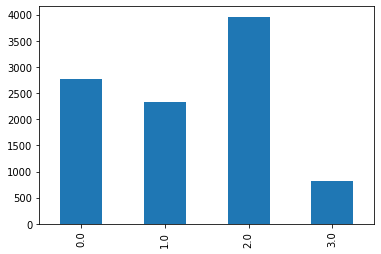

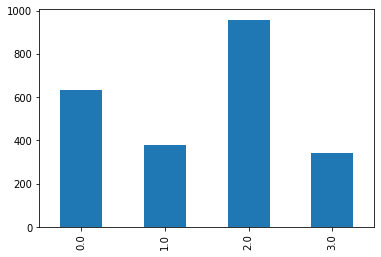

In [16]:
# Visualize the dataset

plt.figure()
df_metadata_train['label'].value_counts().sort_index().plot(kind='bar')

plt.figure()
df_metadata_test['label'].value_counts().sort_index().plot(kind='bar')

In [17]:
# Split training dataset to Train and Validation
df_metadata_train, df_metadata_valid = train_test_split(df_metadata_train,
                                       test_size = 0.1,
                                       random_state = 2018,
                                       stratify = df_metadata_train['label'],
                                       shuffle=True)

print("How many data for training:", df_metadata_train.shape[0])
print("How many data for validation:", df_metadata_valid.shape[0])
print("How many data for testing:", df_metadata_test.shape[0])

How many data for training: 8885
How many data for validation: 988
How many data for testing: 2309


## Helper functions for generating batches of 16 samples for training

In [34]:
IMG_SIZE = (240, 240)
BATCH_SIZE = 32

core_idg = ImageDataGenerator(preprocessing_function = preprocess_input)

def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(IMAGES_DIR)

    df_gen = img_data_gen.flow_from_directory(base_dir,
                                     class_mode = 'sparse',
                                    **dflow_args)

    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''
    return df_gen


train_gen = flow_from_dataframe(core_idg,
                                df_metadata_train,
                                path_col = 'image_path',
                                y_col = 'label',
                                target_size = IMG_SIZE,
                                batch_size = BATCH_SIZE)

valid_gen = flow_from_dataframe(core_idg,
                                df_metadata_valid,
                                path_col = 'image_path',
                                y_col = 'label',
                                target_size = IMG_SIZE,
                                batch_size = BATCH_SIZE)

test_gen = flow_from_dataframe(core_idg,
                               df_metadata_test,
                               path_col = 'image_path',
                               y_col = 'label',
                               target_size = IMG_SIZE)

Found 19371 images belonging to 1 classes.
Found 19371 images belonging to 1 classes.
Found 19371 images belonging to 1 classes.


## Model

The model that we used as a base is the pretrained network (EfficientNet) and use only convolutional and pooling layers.
After that we added some BatchNormalization layers, max-pooling, dropout and final dense layers with 4 neurons.



In [22]:
# Define how the model will look like

base_efficientnet_model = EfficientNetB1(input_shape =  (240, 240, 3), include_top = False, weights = 'imagenet')

age_model = Sequential()
age_model.add(BatchNormalization(input_shape =  (240, 240, 3)))
age_model.add(base_efficientnet_model)
age_model.add(BatchNormalization())
age_model.add(GlobalMaxPooling2D())
age_model.add(Dropout(0.5))
age_model.add(Dense(4, activation = 'softmax'))

## Training

The model is trained with batches of 16 samples and it is set to run on 100 epocs, the classes are also weighted because the dataset is imbalanced.
The loss we decided to use is "sparse categorical cross-entropy" and ADAM optimizer.

In [ ]:
# Training the model
age_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()], optimizer="adam")


checkpoint = ModelCheckpoint(WEIGHT_PATH, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')


# reducing learning rate
reduceLROnPlat = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', factor=0.1, patience=3, mode="max")
early = EarlyStopping(monitor="val_sparse_categorical_accuracy",
                      mode="max",
                      patience=10)

tensorboard = TensorBoard(log_dir=RESULTS_DIR + "logs/{}".format(time()))
callbacks_list = [checkpoint, tensorboard, early, reduceLROnPlat]

class_weights = class_weight.compute_class_weight('balanced',np.unique(df_metadata_train['label']),df_metadata_train['label'])
class_weights = dict(enumerate(class_weights))

history = age_model.fit(train_gen,
                        validation_data = valid_gen,
                        epochs = 100,
                        callbacks = callbacks_list,
                        shuffle = True,
                        class_weight=class_weights,
                        steps_per_epoch = df_metadata_train.shape[0] // BATCH_SIZE,
                        validation_steps = df_metadata_valid.shape[0] // BATCH_SIZE)


## Helper function for representing the confusion matrix


In [23]:
def plot_confusion_matrix(cm, classes, matrix_name, normalize=False, title='', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Code is taken from scikit-learn.org example.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig = plt.figure("Confusion matrix")
    fig.set_size_inches(22, 22)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

## Evaluation

73/73 [==============================] - 30s 363ms/step


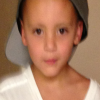

Prediction: 2
Actual: 0.0


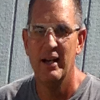

Prediction: 0
Actual: 3.0


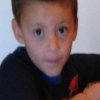

Prediction: 0
Actual: 0.0


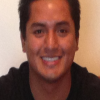

Prediction: 2
Actual: 2.0


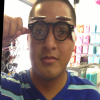

Prediction: 2
Actual: 2.0


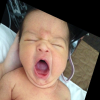

Prediction: 2
Actual: 0.0


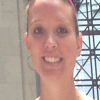

Prediction: 2
Actual: 2.0


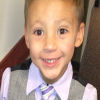

Prediction: 2
Actual: 0.0


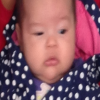

Prediction: 2
Actual: 0.0


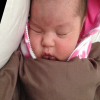

Prediction: 2
Actual: 0.0


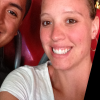

Prediction: 0
Actual: 2.0


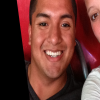

Prediction: 2
Actual: 2.0


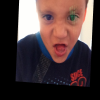

Prediction: 2
Actual: 0.0


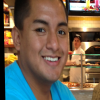

Prediction: 2
Actual: 2.0


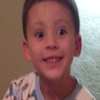

Prediction: 0
Actual: 0.0


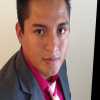

Prediction: 2
Actual: 2.0


In [35]:
# Load the model with best weights
age_model = tf.keras.models.load_model(WEIGHT_PATH)

# Make some predictions on 16 images
pred = age_model.predict(test_gen,
                         verbose=1)
predicted_classes = np.argmax(pred, axis=1)
actual_classes = df_metadata_test['label'].to_numpy()

for i in range(16):
  image_path = IMAGES_DIR + 'images_original/aligned/' + df_metadata_test['image_path'][i]

  image_test = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
  image_test = cv2.resize(image_test, (100, 100), interpolation = cv2.INTER_AREA)
  cv2_imshow(image_test)

  print("Prediction:", predicted_classes[i])
  print("Actual:", actual_classes[i])


Confusion matrix:

Confusion matrix, without normalization
[[ 71   0 562   0]
 [ 35   0 343   0]
 [ 92   0 865   0]
 [ 49   0 292   0]]


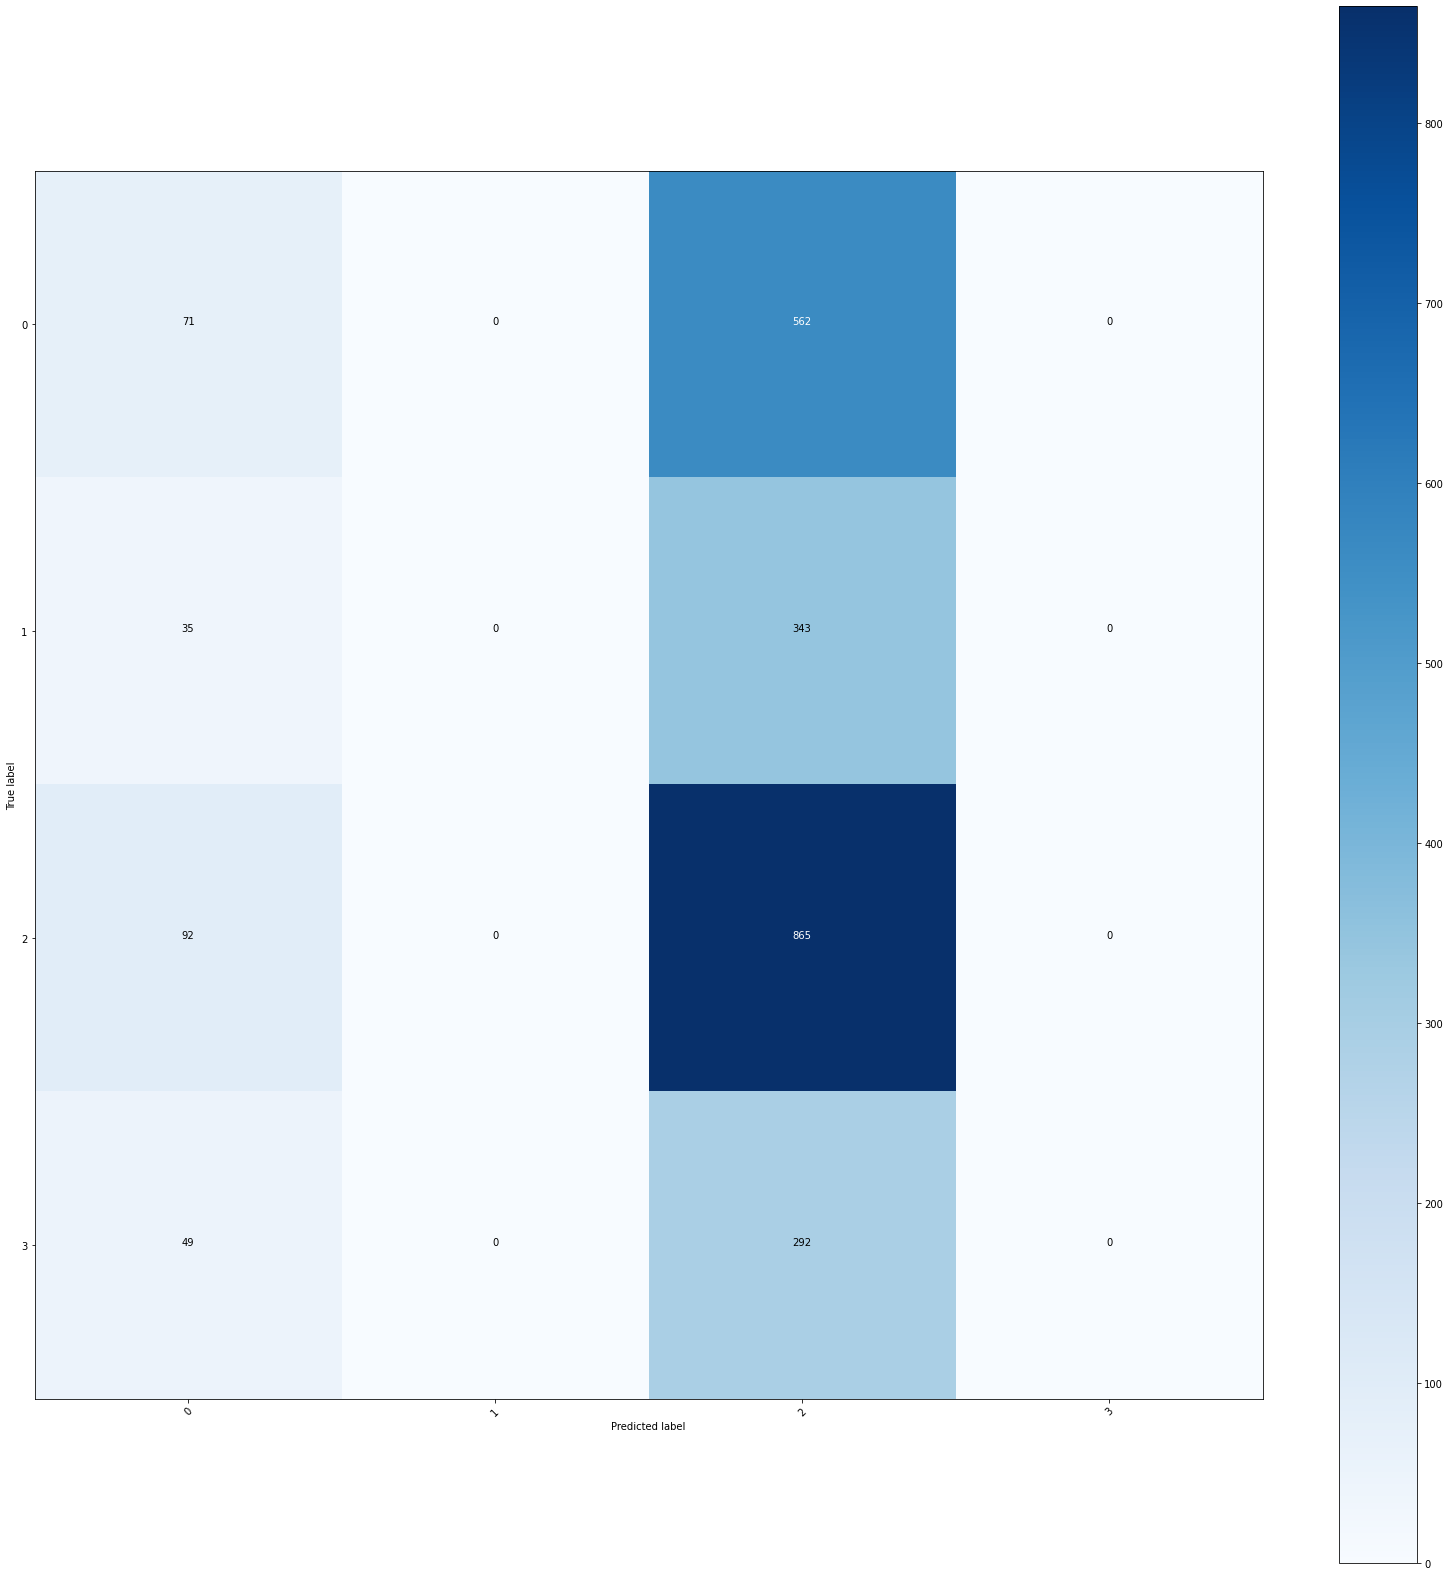

In [38]:
cm = confusion_matrix(actual_classes, predicted_classes)
plot_confusion_matrix(cm, [0, 1, 2, 3], "CNN")

Classification report:


In [41]:
print('\nClassification Report\n')
print(classification_report(actual_classes, predicted_classes, target_names=["0", "1", "2", "3"]))


Classification Report

              precision    recall  f1-score   support

           0       0.29      0.11      0.16       633
           1       0.00      0.00      0.00       378
           2       0.42      0.90      0.57       957
           3       0.00      0.00      0.00       341

    accuracy                           0.41      2309
   macro avg       0.18      0.25      0.18      2309
weighted avg       0.25      0.41      0.28      2309



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC curve:

ROC AUC score: 0.503207947866529


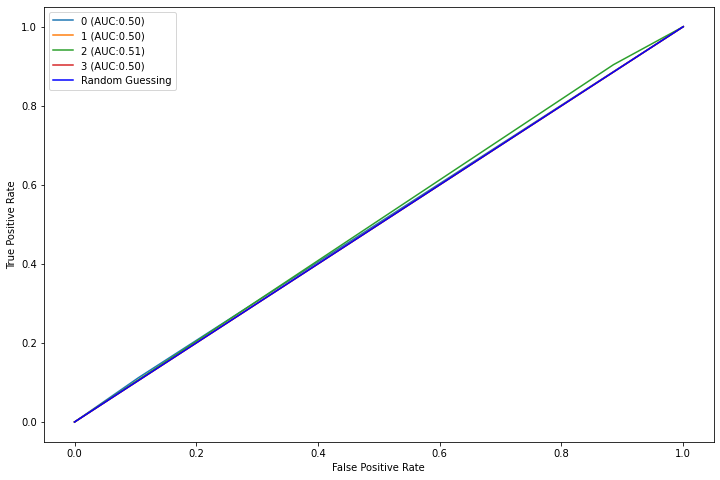

In [43]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate([0, 1, 2, 3]):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(actual_classes, predicted_classes))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()